In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### load in catalogs

In [3]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_22.4'
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+detect_limit+'_formass.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+detect_limit+'_formass.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+detect_limit+'_formass.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']

#### Binary Selection

##### useful functions
fractional scores:\
$s_{sf}=f_c +3f_m - |f_c-f_m|$\
$s_{q}=3f_c +f_m - |f_c-f_m|$$s_{sf}=f_c +3f_m - |f_c-f_m|$

In [4]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

def fraction_score(cat,ic_1, ic_2,slope, diagram_type='',eval_type='q',verbose=False):
    if diagram_type=='NUVrK':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_Ks']
    elif diagram_type=='NUVrz':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_z']
    elif diagram_type=='NUVrJ':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_J']
    else:
        return 1
    
    delta_gv = cat['MAG_ABS_NUV'] - cat['MAG_ABS_r'] - gv_boundary_2(color1, ic_1, ic_2, slope)
    q = delta_gv > 0
    sf = delta_gv < 0
    true_q = cat['CLASS']==0 
    true_sf = cat['CLASS']!=0
    
    if eval_type=='q':
        FP = sum(true_sf*q)  # false positive
        TP = sum(true_q*q)   # true positive
        FN = sum(true_q*sf)  # false negative
        TN = sum(true_sf*sf) # true negative
    else:
        FP = sum(true_q*sf)  # false positive
        TP = sum(true_sf*sf)   # true positive
        FN = sum(true_sf*q)  # false negative
        TN = sum(true_q*q) # true negative
    if verbose:
        print('confusion matrix',FP,TP,FN,TN)
        
    if TP+FP>0:
        fc = FP/(TP+FP)
    else:
        fc=0.99
    
    if TP+FN>0:
        fm = FN/(TP+FN)
    else:
        fm=0.99
    
    if eval_type =='sf':
        return fc, fm, fc + fm + abs(fc-fm)
    else:
        return fc, fm, 2*fc + fm + abs(fc-fm)

# binary selection box parameter search grid
ic_1 = np.linspace(2.6, 4, 7)
ic_2 = np.linspace(1.6, 3.2, 8)
slope = np.linspace(1.0, 2.5, 8)
ic_1_mesh, ic_2_mesh, slope_mesh = np.meshgrid(ic_1, ic_2, slope, indexing='ij')
print('search grid size:',len(ic_1_mesh.ravel()))

search grid size: 448


##### find the selection box


In [5]:
# optimize the selection box
best_box = []
sf_weight = 0.1
diagram_type = 'NUVrK'
for i,cat_name in enumerate(cat_names):
    cat = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat = cat[(cat['lp_zPDF']>0) & (cat['lp_zPDF']<1.5)]
    select_ids = np.random.choice(np.arange(len(cat)), size=8000,replace=False)
    cat = cat[select_ids]
    cat = cat['lp_zPDF','MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_J','MAG_ABS_Ks','CLASS']

    scores = []
    for k in tqdm(range(len(ic_1_mesh.ravel()))):
        fc_sf, fm_sf, score_sf = fraction_score(cat, ic_1_mesh.ravel()[k], ic_2_mesh.ravel()[k], slope_mesh.ravel()[k], diagram_type=diagram_type, eval_type='sf')
        fc_q, fm_q, score_q = fraction_score(cat, ic_1_mesh.ravel()[k], ic_2_mesh.ravel()[k], slope_mesh.ravel()[k], diagram_type=diagram_type,eval_type='q')
        
        if score_sf >= 0 and score_q>0: 
            scores.append(sf_weight*score_sf + (1-sf_weight)*score_q)
        else:
            scores.append(99.)
    
    best_id = np.argmin(np.array(scores))
    ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
    best_box.append([ic_1,ic_2,slope])
    print('best selection box:',[ic_1,ic_2,slope],'best score:',round(np.min(scores),4),'avg. score:',round(np.mean(scores),4),'median score:',round(np.median(scores),4))
    print(' ')

np.save('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy',np.array(best_box))

  0%|          | 2/448 [00:02<08:06,  1.09s/it]


KeyboardInterrupt: 

#### dynesty

In [ ]:
import dynesty
import dynesty.pool as dypool
rstate= np.random.default_rng(56101)
matplotlib.rcParams.update({'font.size': 20})

In [ ]:
cat_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat = Table.read(cat_name.replace('.fits','c20added.fits'))
cat = cat[(cat['lp_zPDF']>0) & (cat['lp_zPDF']<1.5)]
select_ids = np.random.choice(np.arange(len(cat)), size=5000,replace=False)
cat = cat[select_ids]
cat = cat['lp_zPDF','MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_J','MAG_ABS_Ks','CLASS']
print(cat.keys())

In [ ]:
def loglikelihood(theta):
    sf_weight = 0.2
    ic_1,ic_2,slope = theta
    fc_sf, fm_sf, score_sf = fraction_score(cat, ic_1, ic_2, slope, diagram_type='NUVrK', eval_type='sf')
    fc_q, fm_q, score_q = fraction_score(cat, ic_1, ic_2, slope, diagram_type='NUVrK',eval_type='q')
        
    if score_sf >= 0 and score_q>0: 
        score = sf_weight*score_sf + (1-sf_weight)*score_q
    return -np.log(score)

# prior transform
def prior_transform(utheta):
    uic_1, uic_2, uslope = utheta
    ic_1 = 2 * uic_1 + 2.0
    ic_2 = 2 * uic_2 + 1.0
    slope = 2.5 * uslope + 0.5
    return ic_1,ic_2,slope

In [ ]:
with dypool.Pool(6, loglikelihood, prior_transform) as pool:
    dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk',pool=pool, nlive=2000,rstate=rstate)
    dsampler.run_nested(dlogz_init=0.05, maxbatch=20)
dres = dsampler.results
print(dres.summary())

In [ ]:
from dynesty import plotting as dyplot
labels = [r'$b1$', r'$b2$', r'$m$']
fig, axes = dyplot.traceplot(dsampler.results, labels=labels,fig=plt.subplots(3, 2, figsize=(12, 8)))
fig.tight_layout()

In [ ]:
fig, axes = dyplot.cornerplot(dres,show_titles=True, labels=labels,  fig=plt.subplots(3, 3, figsize=(10, 10)))

#### SVM classifier 

#### Diagrams

In [6]:
from texttable import *
import latextable

                | $f_{c,sf}$ | $f_{m,sf}$ | $f_{c,q}$ | $f_{m,q}$
================+============+============+===========+==========
    Optical     |   1.6\%    |   4.2\%    |  31.4\%   |  12.4\%  
  Optical+NIR   |   1.4\%    |   3.8\%    |  28.6\%   |  10.2\%  
 Optical+IRAC   |   1.5\%    |   2.9\%    |  23.8\%   |  12.0\%  
Full Photometry |   1.6\%    |   2.4\%    |  21.3\%   |  14.3\%  
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			  & $f_{c,sf}$ & $f_{m,sf}$ & $f_{c,q}$ & $f_{m,q}$ \\
			\hline
			Optical & 1.6\% & 4.2\% & 31.4\% & 12.4\% \\
			Optical+NIR & 1.4\% & 3.8\% & 28.6\% & 10.2\% \\
			Optical+IRAC & 1.5\% & 2.9\% & 23.8\% & 12.0\% \\
			Full Photometry & 1.6\% & 2.4\% & 21.3\% & 14.3\% \\
		\end{tabular}
	\end{center}
	\caption{Contamintion and Missing Fraction.}
\end{table}
                | $f_{c,sf}$ | $f_{m,sf}$ | $f_{c,q}$ | $f_{m,q}$
================+============+============+===========+==========
    Optical     |   9.8\%    |   44.3\%   |  29.

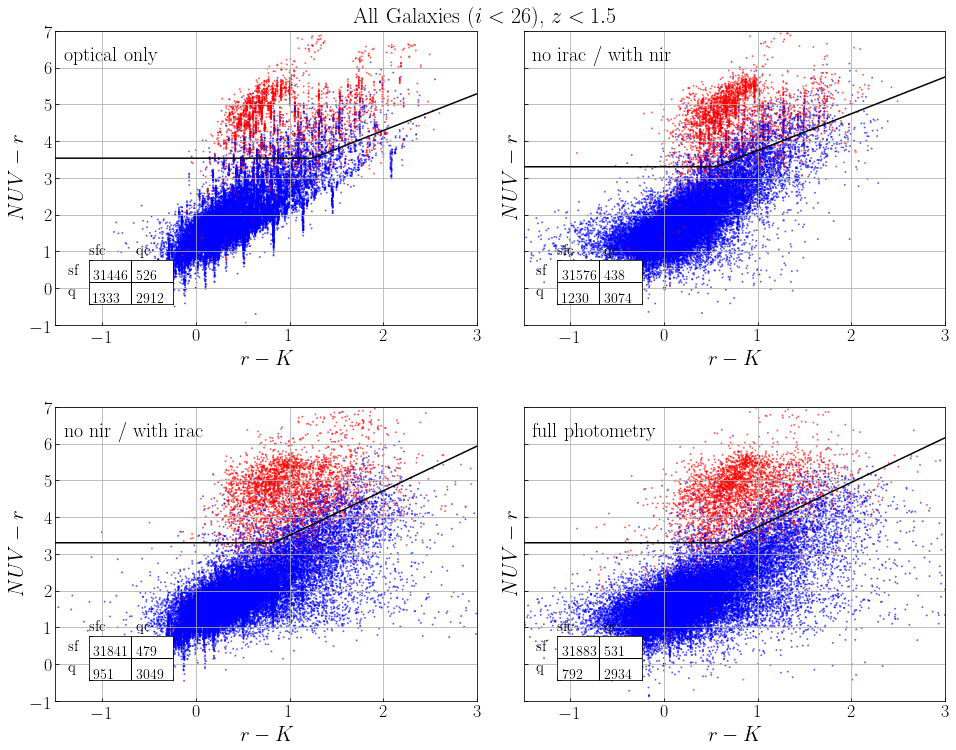

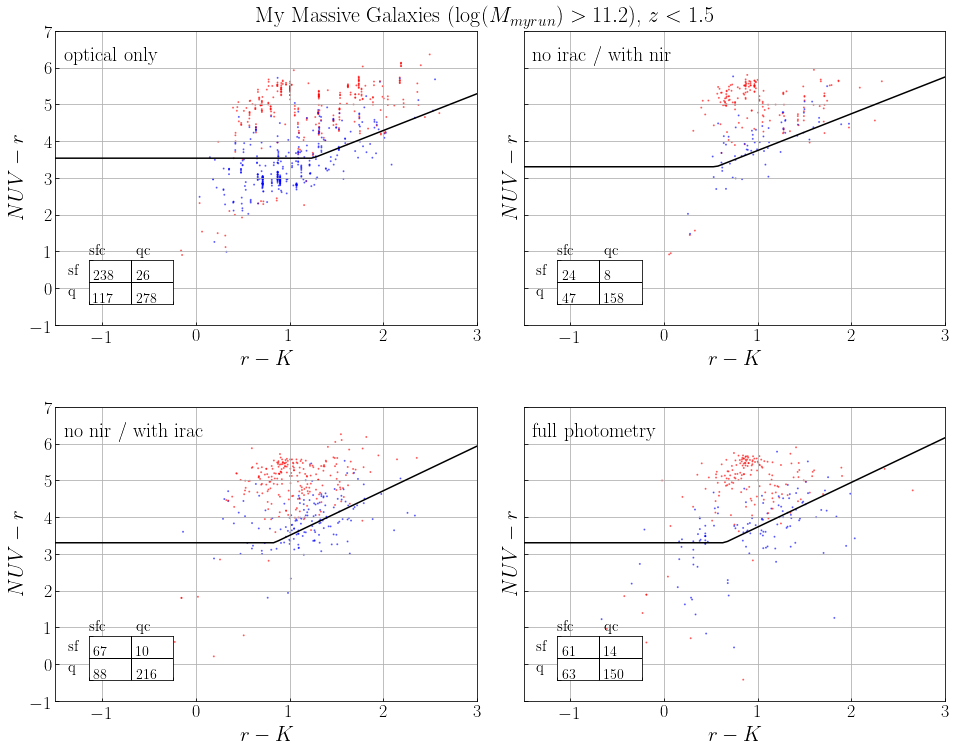

In [7]:
massive_cut=11.2
diagram_type = 'NUVrK'
pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/lejay/Desktop/lephare_'+diagram_type+'.pdf')
zmax=1.5

cat_types = ['Optical','Optical+NIR','Optical+IRAC','Full Photometry']
for selection in ['all','massive']:
    tab_rows = [[' ','$f_{c,sf}$','$f_{m,sf}$','$f_{c,q}$','$f_{m,q}$']]
    fig, axs = plt.subplots(2, 2, figsize = (14, 11), sharey=True)
    for i,cat_name in enumerate(cat_names):
        row = i // 2; col = i % 2
        cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
        cat_output_c20added = cat_output_c20added[(cat_output_c20added['lp_zPDF']>0) & (cat_output_c20added['lp_zPDF']<zmax)]

        # select subsample
        flag_photoz = (cat_output_c20added['flag_photoz']==1)
        if selection == 'all':
            cond = np.ones(len(cat_output_c20added)).astype(bool)
            fig_title = 'All Galaxies ($i<26$)'
        elif selection == 'massive_c20':
            cond = (cat_output_c20added['lp_mass_med']>massive_cut)
            fig_title = 'Truly Massive Galaxies ($\log(M_{C20})>'+str(massive_cut)+'$)'
        elif selection == 'massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)
            fig_title = 'My Massive Galaxies ($\log(M_{myrun})>'+str(massive_cut)+'$)'
        elif selection == 'fake_massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut) & (cat_matched['lp_mass_med']<massive_cut-0.5)
            fig_title = 'Fake Massive Galaxies ($\log(M_{my-run}/M_\odot)>'+str(massive_cut)+' ~ \& ~ \log(M_{C20}/M_\odot)<'+str(massive_cut-0.5)+'$)'
        else:
            raise NameError('wrong name')
        
        # COSMOS consistent photoz objects only
        fig_title += ', $z<'+str(zmax)+'$'
        cond = cond & flag_photoz
        
        # NUVrK selection box
        best_box = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
        axs[row][col].plot(rk_draw, nuv_draw_mid, color='k')
        
        # plot
        if diagram_type == 'NUVrK':
            im = axs[row][col].scatter(cat_output_c20added[cond]['MAG_ABS_r']-cat_output_c20added[cond]['MAG_ABS_Ks'], 
                                   cat_output_c20added[cond]['MAG_ABS_NUV']-cat_output_c20added[cond]['MAG_ABS_r'],
                                   s=1,c=cat_output_c20added[cond]['CLASS'],alpha=0.5,cmap='bwr_r')
            axs[row][col].set_xlabel(r'$r-K$',fontsize=21)
        elif diagram_type == 'NUVrJ':
            im = axs[row][col].scatter(cat_output_c20added[cond]['MAG_ABS_r']-cat_output_c20added[cond]['MAG_ABS_J'], 
                                   cat_output_c20added[cond]['MAG_ABS_NUV']-cat_output_c20added[cond]['MAG_ABS_r'],
                                   s=1,c=cat_output_c20added[cond]['CLASS'],alpha=0.5,cmap='bwr_r')
            axs[row][col].set_xlabel(r'$r-J$',fontsize=21)
        axs[row][col].set_ylabel(r'$NUV-r$',fontsize=21)
        axs[row][col].set_xlim([-1.5,3])
        axs[row][col].set_ylim([-1,7])
        axs[row][col].grid()
        axs[row][col].annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        
        #### contingency table / confusion matrix (inset plot 2) ######
        # q=P sf=N
        cat = cat_output_c20added[cond]
        cat_sf = cat[cat['CLASS']==1]
        cat_q = cat[cat['CLASS']==0]
        if diagram_type == 'NUVrK':
            rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
            rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[i][0],best_box[i][1],best_box[i][2])
        elif diagram_type == 'NUVrJ':
            rj_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_J'])
            rj_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_J']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rj_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rj_q,best_box[i][0],best_box[i][1],best_box[i][2])
        
        # Me - C20
        sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
        q_q = len(cat_q[delta_gv_q>0])      # TP
        sf_q = len(cat_q[delta_gv_q<0])     # FP
        q_sf = len(cat_sf[delta_gv_sf>0])   # FN
        
        f_c_sf = sf_q / (sf_q+sf_sf)
        f_m_sf = q_sf / (sf_q+sf_sf)
        f_c_q = q_sf / (q_q+q_sf)
        f_m_q = sf_q / (q_q+q_sf)
        tab_rows.append([cat_types[i],str(round(f_c_sf*100,1))+'\%',str(round(f_m_sf*100,1))+'\%',
                         str(round(f_c_q*100,1))+'\%',str(round(f_m_q*100,1))+'\%'])
        
        # inset table
        axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
        axs[row][col].annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
        ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
        ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
        ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
        ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
        ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
        ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
        ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
        ax_insert2.set_xlim([-1,1])
        ax_insert2.set_ylim([-1,1])
        ax_insert2.set_yticklabels([])
        ax_insert2.set_xticklabels([])
    
    #generate LaTeX format table
    table = Texttable()
    table.set_cols_align(["c"] * 5)
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(tab_rows)
    print(table.draw())
    print(latextable.draw_latex(table, caption="Contamintion and Missing Fraction."))
        
    plt.suptitle(fig_title,fontsize=22)
    plt.tight_layout(pad=4, w_pad=2)
    pdf.savefig( fig )
pdf.close()

In [ ]:
# write SF/Q flag to catalog

diagram_type = 'NUVrK'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
for phot_type, cat_name in enumerate(cat_names):
    sfq_nuvrk = []
    cat = Table.read(cat_name.replace('.fits','c20added.fits'))
    for i in tqdm(range(len(cat))):
        gal = cat[i]
        if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
            rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
            nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
            if gal['Z_ML']>0 and gal['Z_ML']<1.5:
                delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
                if delta_gv_nuvrk<0:
                    sfq_nuvrk.append(1.)
                else:
                    sfq_nuvrk.append(0.)
            else:
                sfq_nuvrk.append(-99.)
        else:
            sfq_nuvrk.append(99.)
        
    sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
    cat.add_column(sfq_col_nuvrk)
    cat.write(cat_name.replace('.fits','c20added.fits').replace('.fits','_sfq_added.fits'),overwrite=True)

##### split redshift bins
0.2 - 0.5\
0.5 - 0.8\
0.8 - 1.1\
1.1 - 1.5

In [ ]:
massive_cut=11.2
diagram_type = 'NUVrK'
selection = 'massive'

fc_list_overall = [] # contatnimate fraction
fm_list_overall = [] # missed fraction
fc_list_massive = [] # contatnimate fraction
fm_list_massive = [] # missed fraction
zmin_list = np.array([0.2, 0.5, 0.8, 1.1])
zmax_list = np.array([0.5, 0.8, 1.1, 1.5])

# catalog name
cat_name = cat_output_no_nir_mass_name
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))

fig, axs = plt.subplots(2, 4, figsize = (24, 12), sharey=True)
for row,selection in enumerate(['overall','massive']):
    for i,zmin in enumerate(zmin_list):
        cat_output_c20added_z = cat_output_c20added[(cat_output_c20added['lp_zPDF']>zmin) & (cat_output_c20added['lp_zPDF']<zmax_list[i])]
    
        # COSMOS consistent photoz objects only
        if selection is 'massive':
            cond = (cat_output_c20added_z['MASS_MED_massrun']>massive_cut)
        else:
            cond = np.ones(len(cat_output_c20added_z)).astype(bool)
            
        flag_photoz = (cat_output_c20added_z['flag_photoz']==1)
        cond = cond & flag_photoz
            
        # NUVrK selection box
        best_box = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
        rk_draw = np.linspace(-2,3,100)
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
        axs[row][i].plot(rk_draw, nuv_draw_mid, color='k')
        if diagram_type == 'NUVrK':
            im = axs[row][i].scatter(cat_output_c20added_z[cond]['MAG_ABS_r']-cat_output_c20added_z[cond]['MAG_ABS_Ks'], 
                                       cat_output_c20added_z[cond]['MAG_ABS_NUV']-cat_output_c20added_z[cond]['MAG_ABS_r'],
                                       s=4,c=cat_output_c20added_z[cond]['CLASS'],alpha=0.8,cmap='bwr_r')
            axs[row][i].set_xlabel(r'$r-K$',fontsize=21)
        elif diagram_type == 'NUVrJ':
            im = axs[row][i].scatter(cat_output_c20added_z[cond]['MAG_ABS_r']-cat_output_c20added_z[cond]['MAG_ABS_J'], 
                                       cat_output_c20added_z[cond]['MAG_ABS_NUV']-cat_output_c20added_z[cond]['MAG_ABS_r'],
                                       s=4,c=cat_output_c20added_z[cond]['CLASS'],alpha=0.8,cmap='bwr_r')
            axs[row][i].set_xlabel(r'$r-J$',fontsize=21)
        
        axs[row][i].set_ylabel(r'$NUV-r$',fontsize=21)
        axs[row][i].set_xlim([-1.5,3])
        axs[row][i].set_ylim([-1,7])
        axs[row][i].grid()
        axs[row][i].set_title('$'+str(zmin)+'<z<'+str(zmax_list[i])+'$',fontsize=17)
        # plt.annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
            
        #### contingency table / confusion matrix (inset plot 2) ######
        # q=P sf=N
        cat = cat_output_c20added_z[cond]
        cat_sf = cat[cat['CLASS']==1]
        cat_q = cat[cat['CLASS']==0]
        if diagram_type == 'NUVrK':
            rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
            rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[i][0],best_box[i][1],best_box[i][2])
        elif diagram_type == 'NUVrJ':
            rj_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_J'])
            rj_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_J']) 
            delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-gv_boundary_2(rj_sf,best_box[i][0],best_box[i][1],best_box[i][2])
            delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-gv_boundary_2(rj_q,best_box[i][0],best_box[i][1],best_box[i][2])
        
        sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
        q_q = len(cat_q[delta_gv_q>0])      # TP
        sf_q = len(cat_q[delta_gv_q<0])     # FP
        q_sf = len(cat_sf[delta_gv_sf>0])   # FN
        fc = sf_q/(q_q+sf_q)
        fm = q_sf/(q_q+q_sf)
        if selection == 'massive':
            fc_list_massive.append(fc)
            fm_list_massive.append(fm)
        else:
            fc_list_overall.append(fc)
            fm_list_overall.append(fm)
        
        # inset table
        axs[row][i].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][i].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
        axs[row][i].annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
        axs[row][i].annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
        ax_insert2 = axs[row][i].inset_axes([0.08, 0.07, 0.2, 0.15])
        ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
        ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
        ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
        ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
        ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
        ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
        ax_insert2.set_xlim([-1,1])
        ax_insert2.set_ylim([-1,1])
        ax_insert2.set_yticklabels([])
        ax_insert2.set_xticklabels([])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

axs[0].bar(zmin_list,fc_list_overall,width=zmax_list-zmin_list,label='q contam. frac.',align='edge')
axs[1].bar(zmin_list,fm_list_overall,width=zmax_list-zmin_list,label='q missing frac.',align='edge')
axs[0].set_xlabel('$z$',fontsize=18)
axs[1].set_xlabel('$z$',fontsize=18)
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

axs[0].bar(zmin_list,fc_list_massive,width=zmax_list-zmin_list,label='q contam. frac.',align='edge')
axs[1].bar(zmin_list,fm_list_massive,width=zmax_list-zmin_list,label='q missing frac.',align='edge')
axs[0].set_xlabel('$z$',fontsize=18)
axs[1].set_xlabel('$z$',fontsize=18)
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)